 --- 
<h4>Описание задачи:</h4>

     В каждой большой сети появляется необходимость внедрения точных расчетов и получения качественных метрик. 

     Одним из таких показателей явлется метрика ценообразования. Сравнение было одним из ключевых основ, по которым можно делать те или иные выводы! 

      И чем болле дорогостоящий товар, тем острее необходимость не ошибится в субъективном анализе!

      В этом проекте будет уделено внимание автотематике и вопросу ценообразования на автомаркетплейсе. 

      Целью проекта является разработка модели машинного обучения для предсказания цены авто по набору исходных данных, представленных в виде датасета на более чем 400 000 позиций в исторических данных.

---

# 1. Загрузка и ознакомление с данными

In [4]:
!pip install catboost
import numpy as np 
import pandas as pd 
import datetime

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


In [6]:


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [7]:
import warnings
warnings.filterwarnings('ignore')

<h3>Загрузим таблицы</h3>

In [8]:
autodate = pd.read_csv('./train.csv')
autodate_test = pd.read_csv('./test.csv')

In [9]:
submission = pd.read_csv('./sample_submission.csv')

In [10]:
submission = pd.DataFrame()
submission['vin'] = autodate_test['vin']
submission.to_csv(r'./sample_submission.csv',index = False)


<h3>Проверим соответствие данных в датасетах</h3>

In [11]:
print(autodate.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB
None


In [12]:
print(autodate_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          110058 non-null  int64  
 1   make          107997 non-null  object 
 2   model         107979 non-null  object 
 3   trim          107944 non-null  object 
 4   body          107464 non-null  object 
 5   transmission  97047 non-null   object 
 6   vin           110058 non-null  object 
 7   state         110058 non-null  object 
 8   condition     107679 non-null  float64
 9   odometer      110039 non-null  float64
 10  color         109900 non-null  object 
 11  interior      109900 non-null  object 
 12  seller        110058 non-null  object 
 13  saledate      110058 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 11.8+ MB
None


<h4>Вывод: Как и должно быть, типы соответствуют.</h4>

# 2. Предварительная обработка

<h3>Упростим структуру даты, убрав данные часового пояса</h3>

In [14]:
autodate['saledate'] = pd.to_datetime(autodate['saledate'], utc=True).dt.date
autodate_test['saledate'] = pd.to_datetime(autodate_test['saledate'], utc=True).dt.date

In [15]:
autodate.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,2015-06-01
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,2015-02-24
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,2015-06-09
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,2015-06-16
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,2015-02-02


In [16]:
autodate_test.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,2015-01-13
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,2015-02-26
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,2015-02-23
3,2013,Chevrolet,Impala,LS Fleet,Sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,2015-03-05
4,2013,Nissan,Titan,SV,Crew Cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,black,black,nissan north america inc.,2015-06-02


<h3>Проверим наличие дупликатов и пропусков в данных и сделаем предположение о способах их устранения</h3>

In [17]:
autodate.shape

(440236, 15)

In [18]:
autodate_test.shape

(110058, 14)

<h4>Удаляем колонку  "vin". Она не нужна для расчетов</h4>

In [19]:
autodate.drop(columns='vin', inplace=True)
autodate_test.drop(columns='vin', inplace=True)

<h4>Проверим уникальные значения на скрытые дупликаты</h4>

In [20]:
print(autodate['make'].unique())

['Ford' 'Nissan' 'HUMMER' 'Lincoln' 'pontiac' 'Hyundai' nan 'Buick'
 'Chevrolet' 'Honda' 'Acura' 'Cadillac' 'GMC' 'Saab' 'Dodge'
 'Mercedes-Benz' 'Toyota' 'Volkswagen' 'BMW' 'Infiniti' 'Chrysler' 'Kia'
 'Jaguar' 'Subaru' 'Jeep' 'Lexus' 'mercedes' 'Scion' 'FIAT' 'Suzuki'
 'Mazda' 'Volvo' 'Audi' 'MINI' 'Isuzu' 'Mitsubishi' 'smart' 'Pontiac'
 'Porsche' 'subaru' 'ford' 'Land Rover' 'chrysler' 'Saturn' 'mazda'
 'dodge' 'Ram' 'Oldsmobile' 'hyundai' 'Mercury' 'Bentley' 'toyota'
 'lincoln' 'Fisker' 'nissan' 'chevrolet' 'honda' 'porsche' 'mitsubishi'
 'lexus' 'bmw' 'Maserati' 'acura' 'jeep' 'mercury' 'Tesla' 'landrover'
 'vw' 'cadillac' 'buick' 'gmc truck' 'land rover' 'volkswagen'
 'Rolls-Royce' 'audi' 'Ferrari' 'suzuki' 'Plymouth' 'oldsmobile'
 'Lamborghini' 'gmc' 'Geo' 'ford truck' 'Aston Martin' 'plymouth' 'Daewoo'
 'maserati' 'kia' 'mercedes-b' 'dodge tk' 'mazda tk' 'dot' 'airstream']


In [21]:
print(autodate_test['make'].unique())

['Cadillac' 'GMC' 'Nissan' 'Chevrolet' 'Volkswagen' 'Hyundai' 'Ford'
 'Infiniti' 'Subaru' 'Kia' 'BMW' nan 'Mitsubishi' 'Dodge' 'Oldsmobile'
 'Volvo' 'Pontiac' 'Acura' 'Honda' 'Toyota' 'Audi' 'Jeep' 'Lincoln'
 'Chrysler' 'Mercedes-Benz' 'Ram' 'Scion' 'Mercury' 'Lexus' 'Saturn'
 'Mazda' 'Porsche' 'MINI' 'smart' 'Buick' 'HUMMER' 'ford' 'chrysler'
 'Jaguar' 'mitsubishi' 'FIAT' 'Saab' 'mazda' 'Suzuki' 'Land Rover' 'bmw'
 'cadillac' 'oldsmobile' 'honda' 'acura' 'buick' 'landrover' 'Geo' 'lexus'
 'dodge' 'chevrolet' 'chev truck' 'nissan' 'Bentley' 'jeep' 'mercury'
 'toyota' 'gmc' 'Isuzu' 'Aston Martin' 'Maserati' 'land rover' 'kia'
 'subaru' 'Daewoo' 'vw' 'volkswagen' 'Tesla' 'mercedes' 'Ferrari'
 'hyundai' 'pontiac' 'Fisker' 'porsche' 'Rolls-Royce' 'Lotus' 'Plymouth'
 'hyundai tk' 'lincoln' 'ford tk' 'audi']


<h4>Прослеживаются дупликаты. Напишем функцию для их устранения</h4>

In [22]:
def replace_wrong_values(wrong_values, correct_value): 
    for wrong_value in wrong_values: 
        autodate['make'] = autodate['make'].replace(wrong_value, correct_value)
        autodate_test['make'] = autodate_test['make'].replace(wrong_value, correct_value)
        
        autodate['body'] = autodate['body'].replace(wrong_value, correct_value)
        autodate_test['body'] = autodate_test['body'].replace(wrong_value, correct_value)

In [23]:
#def replace_wrong_values1(wrong_values, correct_value): 
 #   for wrong_value in wrong_values: 
  #      autodate_test['make'] = autodate_test['make'].replace(wrong_value, correct_value)

<h4> Сформируем списки дупликатов и основных значений для марки</h4>

In [24]:
duplicates26 = ['mercury']   
name26 = 'Mercury' 
replace_wrong_values(duplicates26,name26) 
duplicates25 = ['lincoln']   
name25 = 'Lincoln' 
replace_wrong_values(duplicates25,name25) 
duplicates24 = ['lexus']     
name24 = 'Lexus'   
replace_wrong_values(duplicates24,name24) 
duplicates23 = ['maserati']  
name23 = 'Maserati'  
replace_wrong_values(duplicates23,name23) 
duplicates22 = ['plymouth']  
name22 = 'Plymouth'  
replace_wrong_values(duplicates22,name22) 
        
duplicates21 = ['mazda', 'mazda tk']  
name21 = 'Mazda'  
replace_wrong_values(duplicates21,name21)
duplicates20 = ['audi'] 
name20 = 'Audi'         
replace_wrong_values(duplicates20,name20)
duplicates19 = ['porsche'] 
name19 = 'Porsche'  
replace_wrong_values(duplicates19,name19)
duplicates18 = ['mitsubishi'] 
name18 = 'Mitsubishi' 
replace_wrong_values(duplicates18,name18)
duplicates17 = ['landrover', 'land rover'] 
name17 = 'Land Rover'  
replace_wrong_values(duplicates17,name17)

duplicates16 = ['mercedes-b', 'mercedes'] 
name16 = 'Mercedes-Benz'  
replace_wrong_values(duplicates16,name16)
duplicates15 = ['volkswagen', 'vw']  
name15 = 'Volkswagen'  
replace_wrong_values(duplicates15,name15)
duplicates14 = ['bmw']  
name14 = 'BMW'  
replace_wrong_values(duplicates14,name14)
duplicates13 = ['kia']  
name13 = 'Kia'  
replace_wrong_values(duplicates13,name13)
duplicates12 = ['suzuki']  
name12 = 'Suzuki'  
replace_wrong_values(duplicates12,name12)

duplicates11 = ['honda']  
name11 = 'Honda'  
replace_wrong_values(duplicates11,name11)
duplicates10 = ['acura']  
name10 = 'Acura'  
replace_wrong_values(duplicates10,name10)
duplicates9 = ['cadillac'] 
name9 = 'Cadillac'  
replace_wrong_values(duplicates9,name9)
duplicates8 = ['gmc truck', 'gmc']  
name8 = 'GMC'  
replace_wrong_values(duplicates8,name8)
duplicates7 = ['dodge', 'dodge tk']  
name7 = 'Dodge'  
replace_wrong_values(duplicates7,name7)

duplicates1 = ['ford', 'ford truck', 'ford tk']  
name1 = 'Ford'  
replace_wrong_values(duplicates1,name1)
duplicates2 = ['nissan']   
name2 = 'Nissan'  
replace_wrong_values(duplicates2,name2)
duplicates3 = ['pontiac']  
name3 = 'Pontiac' 
replace_wrong_values(duplicates3,name3)
duplicates4 = ['hyundai']   
name4 = 'Hyundai'  
replace_wrong_values(duplicates4,name4)
duplicates5 = ['buick']  
name5 = 'Buick'
replace_wrong_values(duplicates5,name5)
duplicates6 = ['chevrolet','chev truck'] 
name6 = 'Chevrolet'  
replace_wrong_values(duplicates6,name6) 

duplicates27 = ['dodge tk', 'dodge'] 
name27 = 'Dodge'  
replace_wrong_values(duplicates27,name27)
duplicates28 = ['hyundai tk'] 
name28 = 'Hyundai'  
replace_wrong_values(duplicates28,name28)     
duplicates29 = ['Jeep'] 
name29 = 'Jeep'  
replace_wrong_values(duplicates29,name29)

duplicates30 = ['toyota'] 
name30 = 'Toyota'  
replace_wrong_values(duplicates30,name30)
duplicates31 = ['subaru'] 
name31 = 'Subaru'  
replace_wrong_values(duplicates31,name31)
duplicates32 = ['oldsmobile'] 
name32 = 'Oldsmobile'  
replace_wrong_values(duplicates32,name32)

In [25]:
print(autodate['make'].unique())

['Ford' 'Nissan' 'HUMMER' 'Lincoln' 'Pontiac' 'Hyundai' nan 'Buick'
 'Chevrolet' 'Honda' 'Acura' 'Cadillac' 'GMC' 'Saab' 'Dodge'
 'Mercedes-Benz' 'Toyota' 'Volkswagen' 'BMW' 'Infiniti' 'Chrysler' 'Kia'
 'Jaguar' 'Subaru' 'Jeep' 'Lexus' 'Scion' 'FIAT' 'Suzuki' 'Mazda' 'Volvo'
 'Audi' 'MINI' 'Isuzu' 'Mitsubishi' 'smart' 'Porsche' 'Land Rover'
 'chrysler' 'Saturn' 'Ram' 'Oldsmobile' 'Mercury' 'Bentley' 'Fisker'
 'Maserati' 'jeep' 'Tesla' 'Rolls-Royce' 'Ferrari' 'Plymouth'
 'Lamborghini' 'Geo' 'Aston Martin' 'Daewoo' 'dot' 'airstream']


In [26]:
print(autodate_test['make'].unique())

['Cadillac' 'GMC' 'Nissan' 'Chevrolet' 'Volkswagen' 'Hyundai' 'Ford'
 'Infiniti' 'Subaru' 'Kia' 'BMW' nan 'Mitsubishi' 'Dodge' 'Oldsmobile'
 'Volvo' 'Pontiac' 'Acura' 'Honda' 'Toyota' 'Audi' 'Jeep' 'Lincoln'
 'Chrysler' 'Mercedes-Benz' 'Ram' 'Scion' 'Mercury' 'Lexus' 'Saturn'
 'Mazda' 'Porsche' 'MINI' 'smart' 'Buick' 'HUMMER' 'chrysler' 'Jaguar'
 'FIAT' 'Saab' 'Suzuki' 'Land Rover' 'Geo' 'Bentley' 'jeep' 'Isuzu'
 'Aston Martin' 'Maserati' 'Daewoo' 'Tesla' 'Ferrari' 'Fisker'
 'Rolls-Royce' 'Lotus' 'Plymouth']


<h4> Сформируем списки дупликатов и основных значений для модели</h4>

In [27]:
duplicates_b1 = ['convertible', 'G Convertible', 'g convertible', 'Beetle Convertible', 'G37 Convertible', 'Q60 Convertible', 'beetle convertible', 'g37 convertible', 'granturismo convertible', 'GranTurismo Convertible', 'q60 convertible' ]  
name_b1 = 'Convertible'
replace_wrong_values(duplicates_b1,name_b1)


duplicates_b2 = ['suv']
name_b2 = 'SUV'
replace_wrong_values(duplicates_b2,name_b2)


duplicates_b3 = ['sedan', 'G Sedan', 'g sedan']
name_b3 = 'Sedan'
replace_wrong_values(duplicates_b3,name_b3)


duplicates_b4 = ['minivan', 'e-series van', 'Van', 'E-Series Van', 'van', 'Promaster Cargo Van', 'Transit Van', 'promaster cargo van', 'transit van', 'Ram Van' ]
name_b4 = 'Minivan'
replace_wrong_values(duplicates_b4,name_b4)


duplicates_b5 = ['sedan', 'G Coupe', 'coupe', 'CTS Coupe', 'Koup', 'Elantra Coupe', 'koup', 'g coupe', 'Genesis Coupe', 'G37 Coupe', 'cts coupe', 'genesis coupe', 'q60 coupe', 'CTS-V Coupe', 'elantra coupe', 'Q60 Coupe', 'g37 coupe', 'cts-v coupe']
name_b5 = 'Coupe'
replace_wrong_values(duplicates_b5,name_b5)


duplicates_b6 = ['Quad Cab', 'King Cab', 'extended cab', 'double cab', 'access cab', 'Double Cab', 'crew cab', 'quad cab', 'CrewMax Cab', 'supercab', 'club cab', 'Mega Cab', 'regular-cab', 'Xtracab',  'Club Cab', 'mega cab', 'crewmax cab', 'king cab', 'Cab Plus 4', 'Cab Plus', 'cab plus 4', 'xtracab', 'regular cab', 'Access Cab', 'SuperCab', 'Crew Cab', 'Regular Cab', 'Extended Cab', 'SuperCrew', 'supercrew']
name_b6 = 'Cab'
replace_wrong_values(duplicates_b6,name_b6)


duplicates_b7 = ['wagon', 'tsx sport wagon', 'TSX Sport Wagon', 'CTS Wagon', 'CTS-V Wagon']
name_b7 = 'Wagon'
replace_wrong_values(duplicates_b7,name_b7)


duplicates_b8 = [ 'hatchback']
name_b8 = 'Hatchback'
replace_wrong_values(duplicates_b8,name_b8)

In [28]:
print(autodate['body'].unique())

['SUV' 'Sedan' nan 'Wagon' 'Minivan' 'Cab' 'Coupe' 'Convertible'
 'Hatchback']


In [29]:
print(autodate_test['body'].unique())

['Sedan' 'Minivan' 'SUV' 'Cab' 'Wagon' 'Hatchback' 'Convertible' nan
 'Coupe']


<h4>Проверим пропуски в данных<h4>

In [214]:
print(f'''Пропуски в данных:
{autodate.isna().sum()}''')

Пропуски в данных:
year                0
make             8043
model            8123
trim             8337
body            10393
transmission    51461
state               0
condition        9405
odometer           69
color             586
interior          586
seller              0
sellingprice        0
saledate            0
dtype: int64


In [215]:
print(f'''Пропуски в данных:
{autodate_test.isna().sum()}''')

Пропуски в данных:
year                0
make             2061
model            2079
trim             2114
body             2594
transmission    13011
state               0
condition        2379
odometer           19
color             158
interior          158
seller              0
saledate            0
dtype: int64


<h4>В обоих выборках похожие пропуски, поэтому методы устранения будут одинаковы.</h4>

<h3>1. Имеем пропуски в таких важных столбцах, как make, model, trim, body. Общий объем пропусков равен примерно 2%.</h3>
<h4>Решение: Заполним данными самого распространенного типа Sedan для body  ближайшими по популярности для trim, model, make.</h4>

In [216]:
autodate = autodate.fillna({"make":"Mazda", "model":"T", "trim":"fr", "body": "Sedan"})
autodate_test = autodate_test.fillna({"make":"Mazda", "model":"T", "trim":"fr", "body": "Sedan"})

<h3>2. Около 0.0001 отсутствующих значений в колонках с цветом color, interior.</h3>
<h4>Решение: Заполним одним из ближайших по количеству значений, к этому полю.</h4>

In [217]:
autodate['color'] = autodate['color'].replace('—', 'green').fillna(value='yellow')
autodate_test['color'] = autodate_test['color'].replace('—', 'green').fillna(value='yellow')

In [218]:
autodate['interior'] = autodate['interior'].replace('—', 'brown').fillna(value='silver')
autodate_test['interior'] = autodate_test['interior'].replace('—', 'brown').fillna(value='silver')

<h3>3. По статистике в США более 95% авто снабжены АКПП.</h3>
<h4>Решение: Заполним соответствующим значением колонку transmission.</h4>

In [219]:
autodate['transmission'] = autodate['transmission'].fillna(value='automatic')
autodate_test['transmission'] = autodate_test['transmission'].fillna(value='automatic')

<h3>4. Поле condition имеет около 2% отсутствующих значений</h3>
<h4>Решение: Заполним медианным значением.</h4>

In [220]:
autodate['condition'] = autodate['condition'].fillna(autodate['condition'].mean())
autodate_test['condition'] = autodate_test['condition'].fillna(autodate['condition'].mean())

<h3>5. Поле odometer вообще имеет около 0.00015% пропусков</h3>
<h4>Решение: Заполним средним значением.</h4>

In [221]:
autodate['odometer'] = autodate['odometer'].fillna(autodate['odometer'].mean())
autodate_test['odometer'] = autodate_test['odometer'].fillna(autodate_test['odometer'].mean())

In [222]:
#autodate_test['odometer'] = autodate_test['odometer'].astype('float')

In [223]:
autodate_test['odometer'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 110058 entries, 0 to 110057
Series name: odometer
Non-Null Count   Dtype  
--------------   -----  
110058 non-null  float64
dtypes: float64(1)
memory usage: 860.0 KB


In [224]:
autodate.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          440236 non-null  object 
 2   model         440236 non-null  object 
 3   trim          440236 non-null  object 
 4   body          440236 non-null  object 
 5   transmission  440236 non-null  object 
 6   state         440236 non-null  object 
 7   condition     440236 non-null  float64
 8   odometer      440236 non-null  float64
 9   color         440236 non-null  object 
 10  interior      440236 non-null  object 
 11  seller        440236 non-null  object 
 12  sellingprice  440236 non-null  int64  
 13  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(10)
memory usage: 47.0+ MB


<h3>Проверим</h3>

In [225]:
print(f'''Пропуски в данных x:
{autodate.isna().sum()}''')

Пропуски в данных x:
year            0
make            0
model           0
trim            0
body            0
transmission    0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
sellingprice    0
saledate        0
dtype: int64


In [226]:
print(f'''Пропуски в данных x:
{autodate_test.isna().sum()}''')

Пропуски в данных x:
year            0
make            0
model           0
trim            0
body            0
transmission    0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
saledate        0
dtype: int64


<h3>Посмотрим на рейтинг элементов в категориальных полях</h3>

In [227]:
# Гистограмма для 5-ти самых частых значений    
def bar(data, column):
    """
    График для категориальных полей
    """
    fig, axes = plt.subplots(figsize=(6, 3))
    
    sns.barplot(x=data[column].astype(str).value_counts().index[:40],
                y=data[column].value_counts(normalize=True).values[:40],
                palette='magma')
    plt.title(f'Рейтинг популярности в категории "{column}"',
              size=15)
    plt.ylabel('Persent')
    
    plt.xticks(rotation=90)
    plt.subplots_adjust(wspace=0.2);

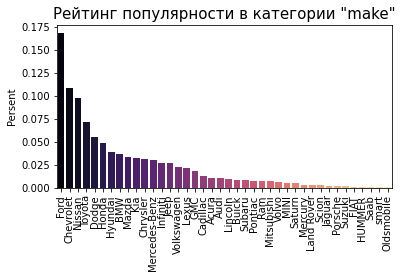

In [228]:
bar(autodate,'make')

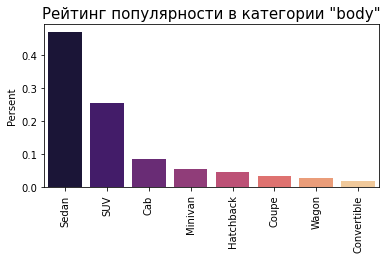

In [229]:
bar(autodate,'body')

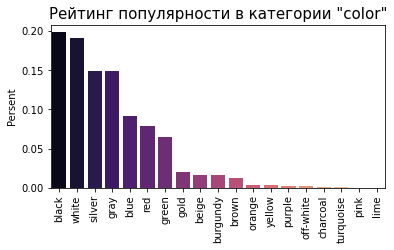

In [230]:
bar(autodate,'color')

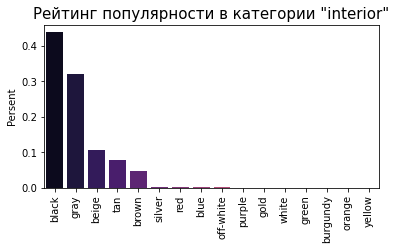

In [231]:
bar(autodate,'interior')

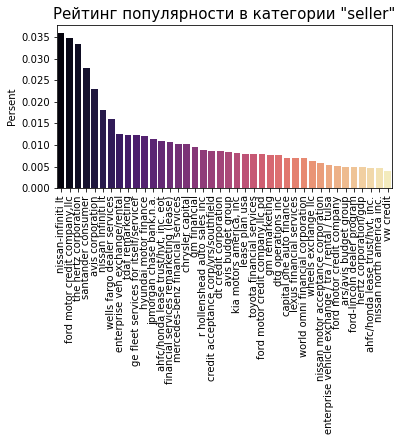

In [232]:
bar(autodate,'seller')

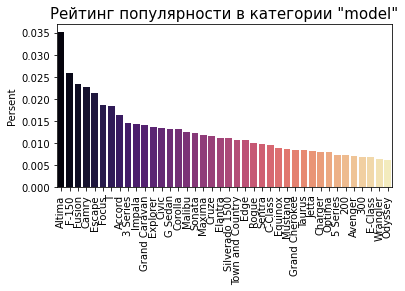

In [233]:
bar(autodate,'model')

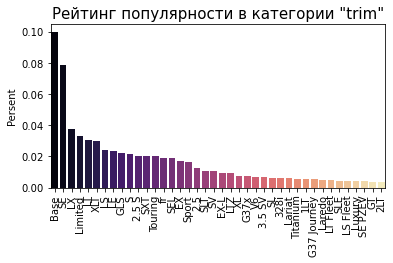

In [234]:
bar(autodate,'trim')

<h4>Проверим поля с большим объемом уникальных значений</h4>

In [235]:
(autodate.groupby('model')['model'].nunique())

model
1 Series     1
1500         1
190-Class    1
2 Series     1
200          1
            ..
xA           1
xB           1
xD           1
yaris        1
yukon        1
Name: model, Length: 960, dtype: int64

In [236]:
(autodate.groupby('trim')['trim'].nunique())

trim
!                     1
& coun fwd            1
& coun fwd limited    1
& coun fwd lx         1
& country lx          1
                     ..
xr                    1
xr-7                  1
yuk xl 4x2 slt        1
z06                   1
zx3                   1
Name: trim, Length: 1923, dtype: int64

In [237]:
(autodate.groupby('seller')['seller'].nunique())

seller
1 cochran of monroeville    1
1 for all auto sales        1
1360250 alberta ltd.        1
138 auto inc                1
143 auto sales inc          1
                           ..
zippy rent a car llc        1
zmax moto leasing inc       1
zonemotors.com inc          1
zoom auto                   1
zygi auto corp              1
Name: seller, Length: 13025, dtype: int64

<h4>Исходя из рейтинга поля trim, видно что 10% занимает значение base, а так как ни одна из марок не имеет такой популярности и такое значение может отностися к разным маркам, то это может создать дополнительные помехи при обучении. Исключим ее из дальнейшей обработки, равно как и колонку seller, которая имеет более 13000 уникальных значений, с максимальным процентом 3,5% от общего количества ретеллеров. Это практически равномерное распрелеление по стране. Предположу, что это не является показателем при формировании цены.</h4>

In [238]:
autodate.head()

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,SUV,automatic,md,4.2,111041.0,black,black,santander consumer,12500,2015-06-01
1,2014,Ford,Fusion,SE,Sedan,automatic,mo,3.5,31034.0,black,black,ars/avis budget group,14500,2015-02-24
2,2012,Nissan,Sentra,2.0 SL,Sedan,automatic,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,2015-06-09
3,2003,HUMMER,H2,Base,SUV,automatic,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,2015-06-16
4,2007,Ford,Fusion,SEL,Sedan,automatic,md,2.0,127709.0,black,black,purple heart,1300,2015-02-02


In [42]:
autodate_test.head()

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,saledate
0,2005,Cadillac,CTS,Base,Sedan,automatic,ca,2.7,116970.0,silver,black,lexus of stevens creek,2015-01-13
1,2014,GMC,Savana Cargo,2500,Minivan,NaN,pa,4.4,6286.0,white,gray,u-haul,2015-02-26
2,2013,Nissan,Murano,S,SUV,automatic,oh,4.6,11831.0,gray,black,nissan-infiniti lt,2015-02-23
3,2013,Chevrolet,Impala,LS Fleet,Sedan,automatic,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,2015-03-05
4,2013,Nissan,Titan,SV,Cab,automatic,tn,2.9,31083.0,black,black,nissan north america inc.,2015-06-02


# 3. Разработка синтетических данных

<h4>Разложим дату на дополнительные фитчи</h4>

In [240]:
# Для трейна
autodate['sl_year'] = pd.to_datetime(autodate['saledate'], utc=True).dt.year
autodate['sl_quarter'] = pd.to_datetime(autodate['saledate'], utc=True).dt.quarter
autodate['s_month'] = pd.to_datetime(autodate['saledate'], utc=True).dt.month
autodate['sl_weekday'] = pd.to_datetime(autodate['saledate'], utc=True).dt.weekday
autodate['s_day'] = pd.to_datetime(autodate['saledate'], utc=True).dt.day

In [241]:
#Для теста
autodate_test['sl_year'] = pd.to_datetime(autodate_test['saledate'], utc=True).dt.year
autodate_test['sl_quarter'] = pd.to_datetime(autodate_test['saledate'], utc=True).dt.quarter
autodate_test['s_month'] = pd.to_datetime(autodate_test['saledate'], utc=True).dt.month
autodate_test['sl_weekday'] = pd.to_datetime(autodate_test['saledate'], utc=True).dt.weekday
autodate_test['s_day'] = pd.to_datetime(autodate_test['saledate'], utc=True).dt.day

In [242]:
#Создадим новый признак - возраст
age = autodate['sl_year'] - autodate['year']
age_t = autodate_test['sl_year'] - autodate_test['year']

In [243]:
date_decomp = pd.DataFrame({'s_day': autodate['s_day'],'sl_weekday': autodate['sl_weekday'],'s_month': autodate['s_month'], 'sl_quarter': autodate['sl_quarter'],'sl_year':autodate['sl_year'], 'age': age })
date_decomp.head()

,s_day,sl_weekday,s_month,sl_quarter,sl_year,age
0,1,0,6,2,2015,4
1,24,1,2,1,2015,1
2,9,1,6,2,2015,3
3,16,1,6,2,2015,12
4,2,0,2,1,2015,8


In [244]:
date_decomp_test = pd.DataFrame({'s_day': autodate_test['s_day'],'sl_weekday': autodate_test['sl_weekday'],'s_month': autodate_test['s_month'], 'sl_quarter': autodate_test['sl_quarter'],'sl_year':autodate_test['sl_year'], 'age': age_t})
date_decomp_test.head()

,s_day,sl_weekday,s_month,sl_quarter,sl_year,age
0,13,1,1,1,2015,10
1,26,3,2,1,2015,1
2,23,0,2,1,2015,2
3,5,3,3,1,2015,2
4,2,1,6,2,2015,2


In [245]:
autodate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          440236 non-null  object 
 2   model         440236 non-null  object 
 3   trim          440236 non-null  object 
 4   body          440236 non-null  object 
 5   transmission  440236 non-null  object 
 6   state         440236 non-null  object 
 7   condition     440236 non-null  float64
 8   odometer      440236 non-null  float64
 9   color         440236 non-null  object 
 10  interior      440236 non-null  object 
 11  seller        440236 non-null  object 
 12  sellingprice  440236 non-null  int64  
 13  saledate      440236 non-null  object 
 14  sl_year       440236 non-null  int64  
 15  sl_quarter    440236 non-null  int64  
 16  s_month       440236 non-null  int64  
 17  sl_weekday    440236 non-null  int64  
 18  s_da

<h3>Подготовим данные к обучению моделью</h3>

In [246]:
#Сбросим первоначальный стоблец с датой
autodate.drop(columns='saledate', inplace=True)
autodate_test.drop(columns='saledate', inplace=True)

In [247]:
#Сбросим столбец seller
autodate.drop(columns='seller', inplace=True)
autodate_test.drop(columns='seller', inplace=True)

In [248]:
#Сбросим столбец trim
autodate.drop(columns='trim', inplace=True)
autodate_test.drop(columns='trim', inplace=True)

In [251]:
# Разделим категориальные и количественные признаки в два разных датафрейма для теста
autodate_cat = autodate[['make', 'model', 'body', 'transmission', 'state','color', 'interior']] 
autodate_col = autodate[['year', 'condition', 'odometer', 'sellingprice']] 

In [252]:
print(autodate.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          440236 non-null  object 
 2   model         440236 non-null  object 
 3   body          440236 non-null  object 
 4   transmission  440236 non-null  object 
 5   state         440236 non-null  object 
 6   condition     440236 non-null  float64
 7   odometer      440236 non-null  float64
 8   color         440236 non-null  object 
 9   interior      440236 non-null  object 
 10  sellingprice  440236 non-null  int64  
 11  sl_year       440236 non-null  int64  
 12  sl_quarter    440236 non-null  int64  
 13  s_month       440236 non-null  int64  
 14  sl_weekday    440236 non-null  int64  
 15  s_day         440236 non-null  int64  
dtypes: float64(2), int64(7), object(7)
memory usage: 53.7+ MB
None


In [253]:
# для трейна
autodate_cat_test = autodate_test[['make', 'model', 'body', 'transmission', 'state','color', 'interior']] 
autodate_col_test = autodate_test[['year', 'condition', 'odometer']] 

In [254]:
#Преобразуем категориальные признаки и объеденим их в датафрем, создадим второй датафрейм для числовых признаков
encoder = OrdinalEncoder()
autodate_cat = pd.DataFrame(encoder.fit_transform(autodate_cat),columns=autodate_cat.columns) 
 #Для теста
autodate_cat_test = pd.DataFrame(encoder.fit_transform(autodate_cat_test),columns=autodate_cat_test.columns) 


In [255]:
autodate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          440236 non-null  object 
 2   model         440236 non-null  object 
 3   body          440236 non-null  object 
 4   transmission  440236 non-null  object 
 5   state         440236 non-null  object 
 6   condition     440236 non-null  float64
 7   odometer      440236 non-null  float64
 8   color         440236 non-null  object 
 9   interior      440236 non-null  object 
 10  sellingprice  440236 non-null  int64  
 11  sl_year       440236 non-null  int64  
 12  sl_quarter    440236 non-null  int64  
 13  s_month       440236 non-null  int64  
 14  sl_weekday    440236 non-null  int64  
 15  s_day         440236 non-null  int64  
dtypes: float64(2), int64(7), object(7)
memory usage: 53.7+ MB


In [256]:
autodate_col = pd.DataFrame((autodate_col),columns=autodate_col.columns)
autodate_col_test = pd.DataFrame((autodate_col_test),columns=autodate_col_test.columns) 

In [257]:
#Объеденим обе части таблицы
autodate = pd.concat([autodate_cat, autodate_col,date_decomp], axis = 1)
autodate = autodate[['year','make','model', 'body','transmission','state', 'color', 'condition', 'odometer', 'interior', 'sellingprice','s_day','sl_weekday','s_month','sl_quarter', 'sl_year', 'age']]
autodate.head()

,year,make,model,body,transmission,state,color,condition,odometer,interior,sellingprice,s_day,sl_weekday,s_month,sl_quarter,sl_year,age
0,2011,14.0,229.0,5.0,0.0,12.0,1.0,4.2,111041.0,1.0,12500,1,0,6,2,2015,4
1,2014,14.0,297.0,6.0,0.0,15.0,1.0,3.5,31034.0,1.0,14500,24,1,2,1,2015,1
2,2012,35.0,617.0,6.0,0.0,19.0,1.0,2.2,35619.0,1.0,9100,9,1,6,2,2015,3
3,2003,17.0,347.0,5.0,0.0,33.0,6.0,2.8,131301.0,0.0,13300,16,1,6,2,2015,12
4,2007,14.0,297.0,6.0,0.0,12.0,1.0,2.0,127709.0,1.0,1300,2,0,2,1,2015,8


In [258]:
#Объеденим обе части для теста
autodate_test = pd.concat([autodate_cat_test, autodate_col_test, date_decomp_test], axis = 1)
autodate_test = autodate_test[['year','make','model', 'body','transmission','state', 'color','condition', 'odometer', 'interior', 's_day','sl_weekday','s_month','sl_quarter', 'sl_year', 'age']]
autodate_test.head()

,year,make,model,body,transmission,state,color,condition,odometer,interior,s_day,sl_weekday,s_month,sl_quarter,sl_year,age
0,2005,6.0,114.0,6.0,0.0,3.0,15.0,2.7,116970.0,1.0,13,1,1,1,2015,10
1,2014,15.0,557.0,4.0,0.0,28.0,17.0,4.4,6286.0,6.0,26,3,2,1,2015,1
2,2013,35.0,425.0,5.0,0.0,24.0,7.0,4.6,11831.0,1.0,23,0,2,1,2015,2
3,2013,7.0,327.0,6.0,0.0,5.0,15.0,2.3,57105.0,1.0,5,3,3,1,2015,2
4,2013,35.0,619.0,0.0,0.0,32.0,1.0,2.9,31083.0,1.0,2,1,6,2,2015,2


In [259]:
autodate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          440236 non-null  float64
 2   model         440236 non-null  float64
 3   body          440236 non-null  float64
 4   transmission  440236 non-null  float64
 5   state         440236 non-null  float64
 6   color         440236 non-null  float64
 7   condition     440236 non-null  float64
 8   odometer      440236 non-null  float64
 9   interior      440236 non-null  float64
 10  sellingprice  440236 non-null  int64  
 11  s_day         440236 non-null  int64  
 12  sl_weekday    440236 non-null  int64  
 13  s_month       440236 non-null  int64  
 14  sl_quarter    440236 non-null  int64  
 15  sl_year       440236 non-null  int64  
 16  age           440236 non-null  int64  
dtypes: float64(9), int64(8)
memory usage: 57.1 MB


In [260]:
autodate_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          110058 non-null  int64  
 1   make          110058 non-null  float64
 2   model         110058 non-null  float64
 3   body          110058 non-null  float64
 4   transmission  110058 non-null  float64
 5   state         110058 non-null  float64
 6   color         110058 non-null  float64
 7   condition     110058 non-null  float64
 8   odometer      110058 non-null  float64
 9   interior      110058 non-null  float64
 10  s_day         110058 non-null  int64  
 11  sl_weekday    110058 non-null  int64  
 12  s_month       110058 non-null  int64  
 13  sl_quarter    110058 non-null  int64  
 14  sl_year       110058 non-null  int64  
 15  age           110058 non-null  int64  
dtypes: float64(9), int64(7)
memory usage: 13.4 MB


# 4. Выбор и обучение моделей

<h4>Разделим данные на выборки</h4>

In [261]:
#Выделим таргет и фьючи:
features = autodate.drop('sellingprice', axis=1)
target = autodate.sellingprice

In [262]:
#разделим данные на выборки:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target, 
                                                                            test_size=.25,
                                                                            random_state=12345)

<h4>Выберем Модель CatBoostRegressor</h4>

In [263]:
%%time

model_cbr = CatBoostRegressor() 
parameters = [{'learning_rate':[.1, .5, .8], 'random_state':[12345], 'verbose':[False]}]

gscv = GridSearchCV(model_cbr, parameters, scoring='neg_mean_squared_error')
gscv.fit(features_train, target_train)

print(gscv.best_params_)

mts = gscv.cv_results_['mean_test_score']
    
gscv_rsme_cbr = (max(mts) * -1) ** .5
gscv_rsme_cbr

{'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}
CPU times: total: 9min 55s
Wall time: 7min 58s


2537.480801273795

In [264]:
%%time
model_cbr = CatBoostRegressor(learning_rate=.5, random_state=12345, verbose=False) #подставил лучшие параметры
model_cbr.fit(features_train, target_train)

CPU times: total: 46.7 s
Wall time: 36.1 s


In [43]:
%%time

target_predict = model_cbr.predict(features_test)

NameError: name 'model_cbr' is not defined

<h3>Проверим модель на тестовых данных</h3>

In [266]:
out_test = autodate_test

In [267]:

%%time
main_predict = model_cbr.predict(out_test)

CPU times: total: 172 ms
Wall time: 54.9 ms


In [270]:
#submission = pd.read_csv('/kaggle/input/cars-price-prediction/submission.csv')
#submission['vin'] = autodate['vin']
submission1 = pd.DataFrame()
#submission['vin'] = autodate_test['vin']
submission['sellingprice'] = main_predict
submission.to_csv(r'./sample_submission.csv',index = False)

In [271]:

submission['sellingprice']

0          3195.025145
1         61095.274630
2         24753.270933
3         11698.869657
4         46303.272800
              ...     
110053    17622.636357
110054    49902.795964
110055     6477.107889
110056    18699.705454
110057    32541.015795
Name: sellingprice, Length: 110058, dtype: float64

In [274]:
submission

,vin,sellingprice
0,1g6dp567450124779,3195.025145
1,1gtw7fca7e1902207,61095.274630
2,jn8az1mw6dw303497,24753.270933
3,2g1wf5e34d1160703,11698.869657
4,1n6aa0ec3dn301209,46303.272800
...,...,...
110053,1j4aa2d17bl584330,17622.636357
110054,jthbf1d23e5007526,49902.795964
110055,1n4ba41e54c831950,6477.107889
110056,jn1az4eh3dm382431,18699.705454


# 5.Вывод

   <h4>В процессе иследования в проекте были реализованны следующие этапы:</h4>

   1. Проведено первичное ознакомление с данными в обучающеи и тестовой выборке. Визуальное ознакомление с данными дало        представление о дальнейших действиях, а именно:
 - Необходимости проработки формата даты для удобства дальнейшего использования
 - Структурированию и форматированию категориальных признаков
 - Исключению данных, которые возможно не несут ценности для обучения

   
   2. Проведено форматирование поля с датой, исключением данных очасовом поясе. Это открыло возможность восприятия моделью данных без искажений и ошибок, а так же открыло горизонт для расширения спектра данных, связанных с этим полем. Был исключен столбец с вин номером автомобиля. При всей его информативности в базах данных авто, в расчетах и обучении модели он является помехой, создавая ненужный шум.
 
   
   3. Была проведена чистка данных и заполнение пропусков в полях с маркой авто и моделью. Было выявленно около 50% скрытых дублей, которые были устранени наряду с пропусками. Наряду с этим, подобным образом были предобработанны поля со всеми данными. Был применен наиболее целесообразный метод для каждой колонки. В полях с числовыми данными это были медианы и средние, в категориальных столбцах, ближайшее подобное значение исходя из анализа.
 
   
   4. Был проведен анализ  рейтингов и удалены столбцы, которые предположительно могли иметь пересечения, к примеру модификация, которая с большой вероятностью может создавать вредный шум при обучении модели. 
 
   
   5. Произведено разделение данных на две категории и кодирование категориальных признаков. После чего данные были объеденены. Все подготовительные работы осуществлялись парралельно на тестовом и тренеровочном датасетах с момента их згрузки для их соответствия.
 
  
  6. Для обучения данных была выбрана модель CatBoostRegressor. Для контроля результатов работы модели была выбрана метрика MSE. Обучение модели производилось два раза. После первичного обучения были исключены предполагаемые поля. В результате получили более качественную метрику, которая улучшилась более чем на 90%.

  
  ИТОГ: В результате исследования был получен метрика, которая трубует улучшения, для уверенной передачи модели в продакшн. В ходе исследования появились идеи и видения которые возможно применить для проекта с целью увеличения точности прогноза моделью, цены автомобиля. В каждой стадии подготовки проекта можно внести следующие дополнения:
   - Предобработка. Для очистки данных следует обратить внимание на отрицательные значения в данных, которых не должно быть в поле с ценой. Стоит проработать распределение и проработать массив с точки зрения выбросов. Следует построить матрицу корреляции для обнаружения признаков, которые можно удалить(Проверка на мультиколлениарность). Попробовать заменить пропуски на значение  UNCNOW в место значений модели, близких по значению.(Так возможно убрать искажение из конкретной марки, которой добавляются данные).
   - Фитчинженерия. Следует добавить поле с проработкой данных по винномеру, который связан с региональными и другими данными. Разбить поле с ценой на несколько категорий по принципу бютжет, вип, лакшари. Добавить поле со страной производителя и расположенность по континентам. Так же, поле со штатами можно попробовать разделить на части:  север, восток, юг, запад. Для автоматического подбора новых признаков стоит использовать библиотеку Fitcher tools  и полином фитчерс для обнаружения нелинейных закономерностей, что позволит значительно обогатить датасет и увеличить точность предсказаний. Применить библиотеку шаб для оценки важности признаков. Ознакомиться с методами ансамблирования и стейкинга.
   - Обучение. Конечно же для более точного предсказания требуется использование нескольких моделей. Эксперименты с гиперпараметрами в этом процессе несут основополагающую роль. Для автоматического подбора гиперпараметров провести обучение с использованием метода optuna. 
 